# Homework 2 - Data from the web#

In [118]:
# Import libraries 
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import requests 
from collections import*
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [119]:
params = {'legend.fontsize': 30,
         'axes.labelsize': 30,
         'axes.titlesize': 30,
         'xtick.labelsize':18,
         'ytick.labelsize':18}


matplotlib.rcParams.update(params)

### 1) Obtain the 200 top-ranking universities in www.topuniversities.com (ranking 2018).
In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame and answer the following questions:


* Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?


* Answer the previous question aggregating the data by (c) country and (d) region.


Plot your data using bar charts and describe briefly what you observed.

First of all, thanks to postman we have intercepted the request to the API for the www.topuniversities.com ranking which is : 
https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508252679222

Using the **requests** library, we send a request to get the data into a dataframe.

In [120]:
# Make the request
top_university_url = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508252679222'
response = requests.get(top_university_url)
df = pd.DataFrame( response.json()['data'])

Since we are only interested in the top 200 university along with their name, rank, country, region, number of faculty members and number of students, let's slice the results to keep only relevant information. 

In [121]:
top_university_ranking = df[['title','rank_display','country','region','url']].head(200)

Then we need to add the missing values to our dataframe : 
* The total number of faculty members
* The number of international faculty members
* The number of students 
* The number of international students

To do so, we first limit the results to the top 200 universities using linespace function from numpy library on the display_rank column and then browse the web page provides by the `url` attribute of the previous dataframe for each university using **BeautifulSoup**.

In [122]:
top_university_ranking.rank_display = np.linspace( 1, 200, num=200)

In [123]:
DOM_element = ['total faculty','inter faculty','total student','total inter']

def clean_to_int(x):
    if x==None:
        return None
    else:
        return int(re.sub("[^0-9]", "", x))
    
def scrape(url):
    r = requests.get( "https://www.topuniversities.com" + url )
    page_body = r.text
    soup = BeautifulSoup(r.text, 'html.parser')
    soup = BeautifulSoup(page_body, 'html.parser')
    
    for item in DOM_element:
        #We scrape the element we want
        element = soup.find('div', class_=item)
        
        #if the element exist we clean it
        if element:
            text_element = element.find('div', class_='number').text
            #We clean the text and convert it on integer
            value = clean_to_int(text_element)
        else:
            value = np.nan
        #We store the value in a new column
        top_university_ranking.loc[top_university_ranking.url == url,item] = value
        
for url in top_university_ranking.url:
    scrape(url)

Finally, we rename columns to more explicit names, drop the url column since we don't need it anymore and export the result to a csv file to avoid having to scrape 200 web pages each time we open the notebook.

In [124]:
top_university_ranking=top_university_ranking.rename(index=str, columns={"rank_display": "rank (tur)", 
                                "location": "country",
                                "title": "name",
                                'total faculty':"total faculty members (tur)",
                                'inter faculty':'international faculty members (tur)' ,
                                'total inter': 'international students (tur)',
                                'total student': 'total students (tur)',
                                'stats_number_students': 'total students (tur)'
                               })  

top_university_ranking=top_university_ranking.drop('url',axis=1)

** tur : Top University Ranking (1st ranking)*

Save  this dataframe in a csv file, or read it directly.

In [125]:
top_university_ranking.to_csv('top_university_ranking.csv',index=False)
#top_university_ranking = pd.read_csv('top_university_ranking.csv')
top_university_ranking

,name,rank (tur),country,region,total faculty members (tur),international faculty members (tur),total students (tur),international students (tur)
0,Massachusetts Institute of Technology (MIT),1.0,United States,North America,2982.0,1679.0,11067.0,3717.0
1,Stanford University,2.0,United States,North America,4285.0,2042.0,15878.0,3611.0
2,Harvard University,3.0,United States,North America,4350.0,1311.0,22429.0,5266.0
3,California Institute of Technology (Caltech),4.0,United States,North America,953.0,350.0,2255.0,647.0
4,University of Cambridge,5.0,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0
5,University of Oxford,6.0,United Kingdom,Europe,6750.0,2964.0,19720.0,7353.0
6,UCL (University College London),7.0,United Kingdom,Europe,6345.0,2554.0,31080.0,14854.0
7,Imperial College London,8.0,United Kingdom,Europe,3930.0,2071.0,16090.0,8746.0
8,University of Chicago,9.0,United States,North America,2449.0,635.0,13557.0,3379.0
9,ETH Zurich - Swiss Federal Institute of Techno...,10.0,Switzerland,Europe,2477.0,1886.0,19815.0,7563.0


As a final step, we create a dictionary mapping the country name with a region using the top_university_ranking. The key is the country name and the value is the region. We will use it later on.

In [126]:
region_dict = {'Luxembourg':'Europe',}  #Luxembourg is not in the first classement so we add it manually into the dictionary.
for i in top_university_ranking.country.unique():
     region_dict[i] = top_university_ranking[top_university_ranking.country == i].region.unique().tolist()[0]
region_dict=defaultdict(lambda: 'Unknow', region_dict)

### Analysis:
* ##### Which are the best universities in term of ratio between faculty members and students?

In [127]:
def ratio(col):
    if col[0] == 0:
        return np.nan
    return col[0]/col[1]

def compute_ratio(df,col1,col2):
    return df[[col1,col2]].apply(lambda col:ratio(col), axis=1)

def sorted_ranking(df,col):
    df = df.sort_values(col, ascending=[0])
    df = df.reset_index(drop=True)
    df.index = df.index + 1
    return df

In [128]:
#We conpute the ratio between faculty members and students and add it in the data frame 
top_university_ranking['ratio faculty members/students'] = compute_ratio(top_university_ranking,
                                                                          'total faculty members (tur)',
                                                                          'total students (tur)')

#We display the ranking depending the ratio between faculty members and students
sorted_ranking(top_university_ranking,'ratio faculty members/students')[['name','ratio faculty members/students']]

,name,ratio faculty members/students
1,California Institute of Technology (Caltech),0.422616
2,Yale University,0.398323
3,University of Oxford,0.342292
4,University of Cambridge,0.292488
5,Johns Hopkins University,0.276353
6,Stanford University,0.269870
7,Massachusetts Institute of Technology (MIT),0.269450
8,University of Rochester,0.266604
9,University of Pennsylvania,0.266437
10,Columbia University,0.247115


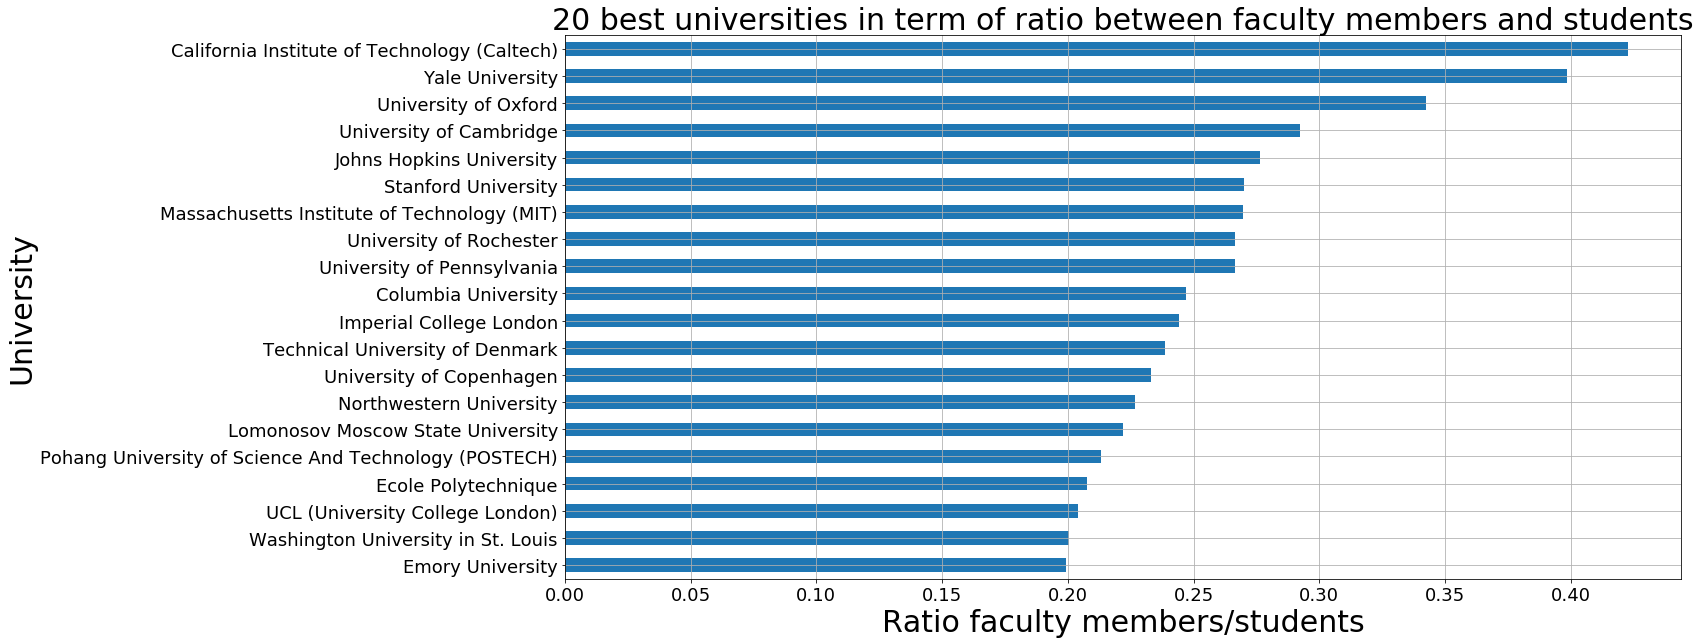

In [129]:
def plot_barh_chart (dataset, x, y, title, xlabel, ylabel) :
    
    ax = sorted_ranking(dataset,y)[:20]\
                      .plot(y=y,
                            x=x,
                            kind='barh',
                            grid=True,
                            figsize=(20, 10))
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend_.remove()
    ax.set_title(title)

    
plot_barh_chart( top_university_ranking , 'name', 'ratio faculty members/students', 
                '20 best universities in term of ratio between faculty members and students', 
                'Ratio faculty members/students', 'University' )

This is interesting to notice that the 11 best universities in term of ratio between faculty members and students are all English or American (USA). California Institute of Technology (Caltech) is the best university in this ranking.
* #####  Which are the best universities in term of ratio of international students?

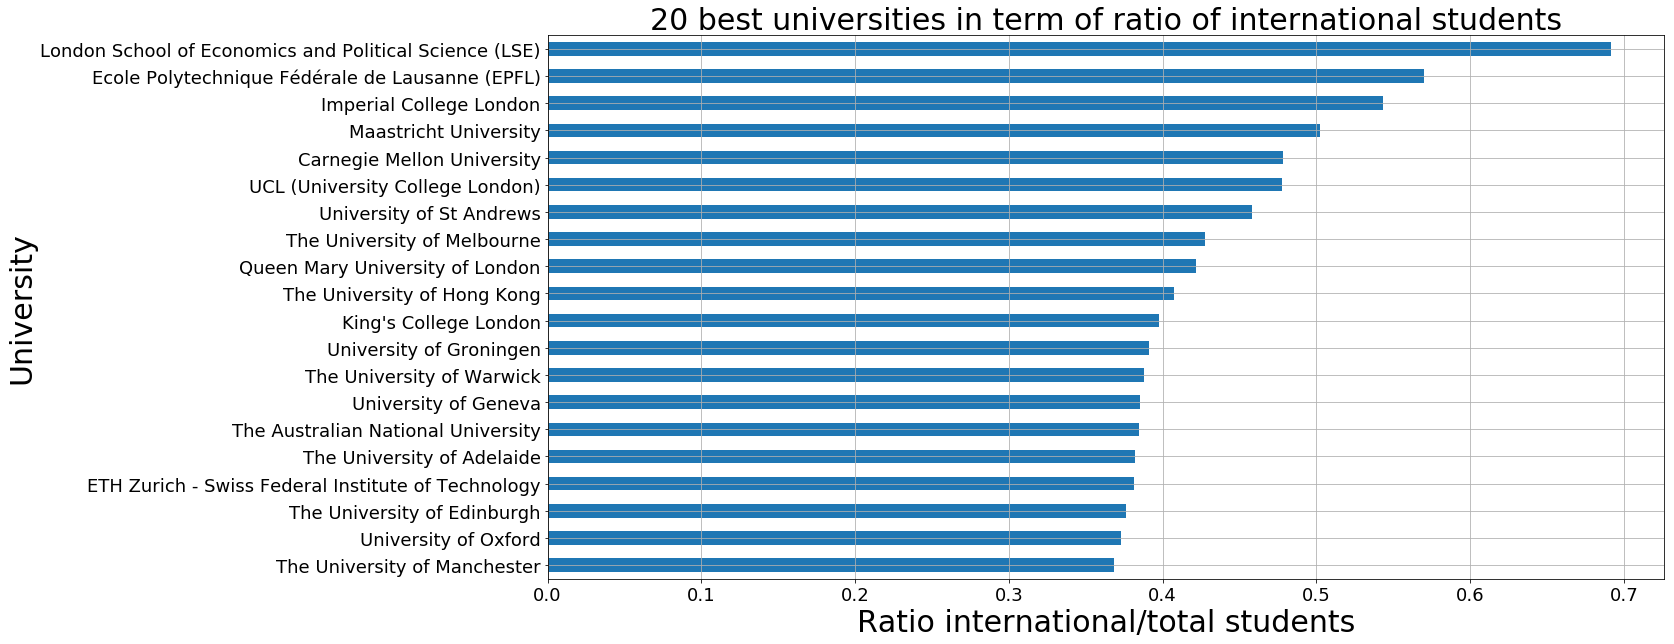

In [130]:
#We conpute the ratio between faculty members and students and add it in the data frame 
top_university_ranking['ratio international/total students'] = compute_ratio(top_university_ranking,
                                                                          'international students (tur)',
                                                                          'total students (tur)')

#We display the ranking depending the ratio between faculty members and students
sorted_ranking(top_university_ranking,
               'ratio international/total students')[['name','ratio international/total students']][:20]

plot_barh_chart( top_university_ranking , 'name', 'ratio international/total students', 
                '20 best universities in term of ratio of international students', 
                'Ratio international/total students', 'University' )

This is interesting to see that EPFL is the second best university in term of international students. We also can notice that a lot of English universities are in this ranking.

* ##### Which are the best countries in term of ratio between faculty members and students?

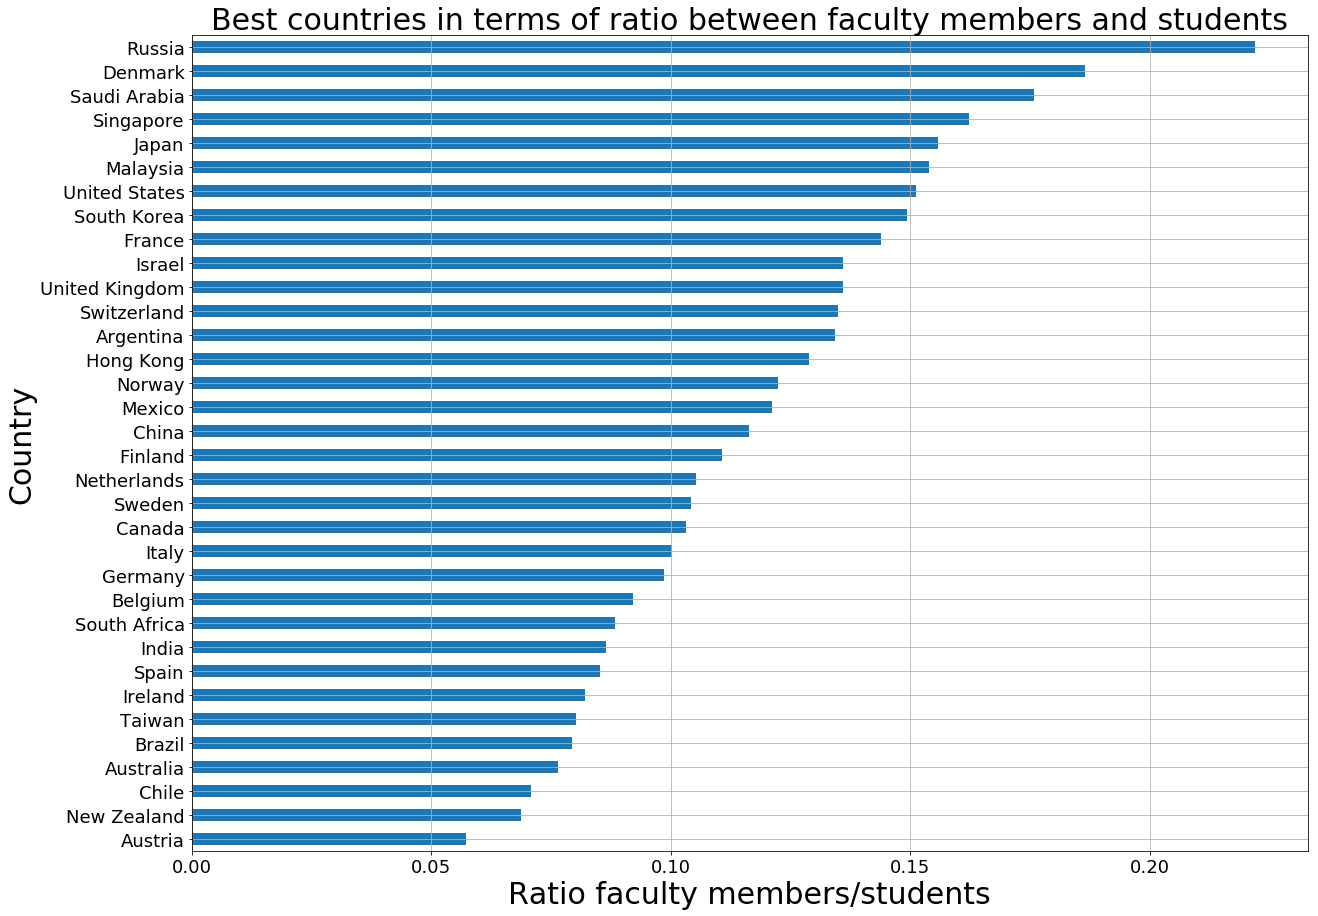

In [131]:
def plot_barh_chart_groupedBy (dataset, value , title, xlabel, ylabel, group, size) :
    
    ax = dataset.groupby(group)\
    .mean()\
    .sort_values(value)\
    .plot(y=value,
          kind='barh',
          grid=True,
          figsize=size)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend_.remove()
    ax.set_title(title)
    
    
plot_barh_chart_groupedBy( top_university_ranking , 'ratio faculty members/students', 
                'Best countries in terms of ratio between faculty members and students', 
                'Ratio faculty members/students', 'Country', 'country',(20, 15) ) 

Russia is the best country in term of ratio between faculty members and students. 
* ##### Which are the best countries in term of ratio of international students?

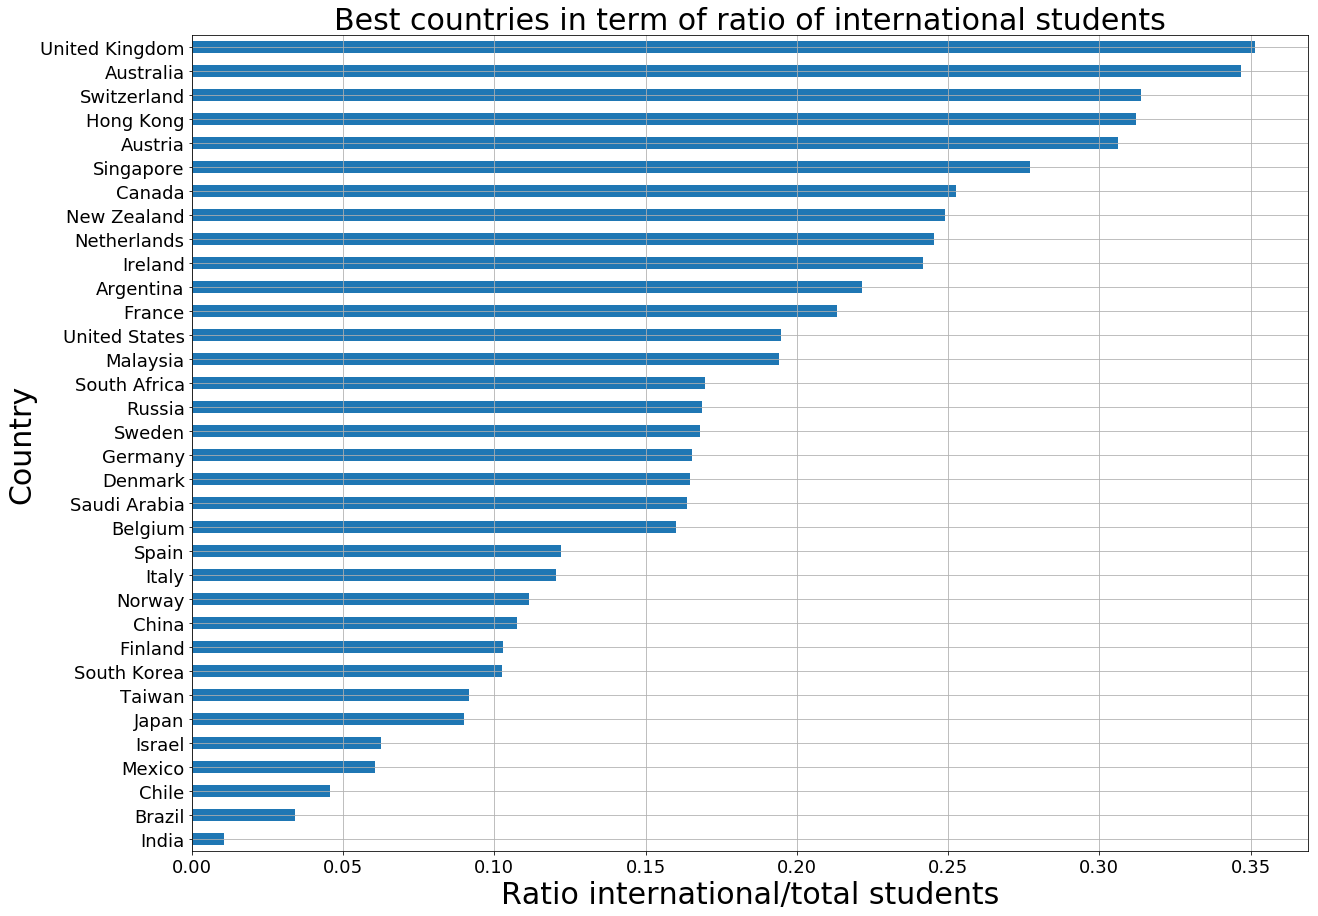

In [132]:
plot_barh_chart_groupedBy( top_university_ranking , 'ratio international/total students', 
                'Best countries in term of ratio of international students', 
                'Ratio international/total students', 'Country', 'country', (20, 15) ) 

One can notice that the countries those host the most international students are English speaking countries. This might be due to the fact that English is now the global language of business. 

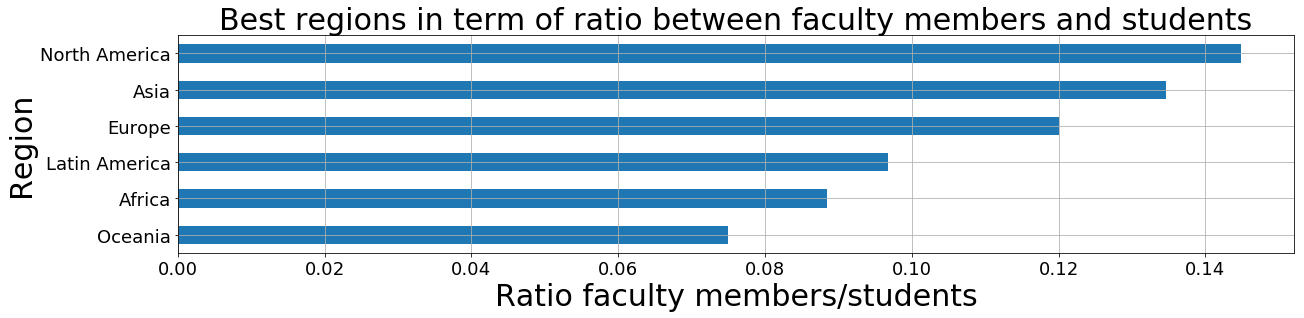

In [133]:
plot_barh_chart_groupedBy( top_university_ranking , 'ratio faculty members/students', 
                'Best regions in term of ratio between faculty members and students', 
                'Ratio faculty members/students', 'Region', 'region', (20,4) ) 

North America has the best international ratio thanks to Canada and United states.


* ##### Which are the best regions in term of ratio of international students?

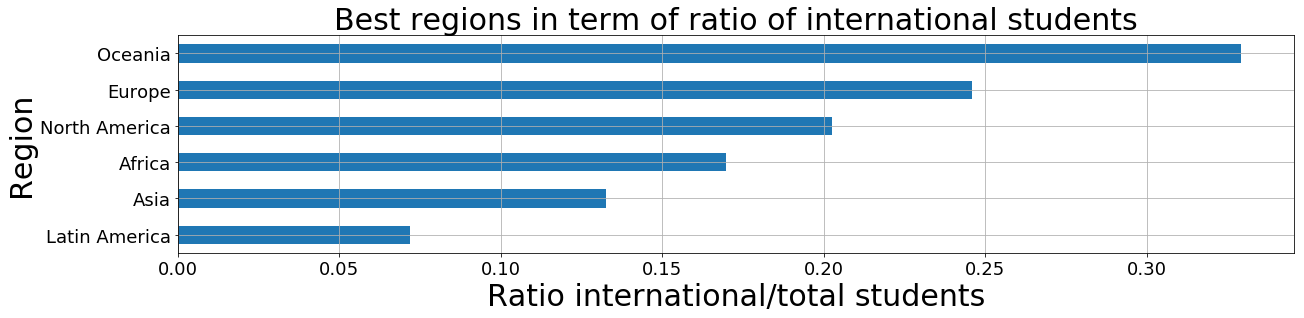

In [134]:
plot_barh_chart_groupedBy( top_university_ranking , 'ratio international/total students', 
                'Best regions in term of ratio of international students', 
                'Ratio international/total students', 'Region', 'region', (20,4) ) 

Oceania has the best international student ratio.

For further analysis, as we won't need the columns `ratio faculty members/students` and `ratio international/total students` anymore let's drop them.

In [135]:
useless_columns = ['ratio faculty members/students','ratio international/total students']
top_university_ranking=top_university_ranking.drop(useless_columns,axis=1)

### 2) Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). Repeat the analysis of the previous point and discuss briefly what you observed.

Once again, postman helped us figured the url used to request the data. The result is returned as a json file.

In [136]:
response = requests.get("https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json")
df = pd.DataFrame( response.json()['data'] )

times_higher_education_ranking = df[['name', 'rank','location',
                                     'stats_number_students',
                                     'stats_student_staff_ratio',
                                     'stats_pc_intl_students']].head(200) 

times_higher_education_ranking

,name,rank,location,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students
0,University of Oxford,1,United Kingdom,"20,409",11.2,38%
1,University of Cambridge,2,United Kingdom,"18,389",10.9,35%
2,California Institute of Technology,=3,United States,"2,209",6.5,27%
3,Stanford University,=3,United States,"15,845",7.5,22%
4,Massachusetts Institute of Technology,5,United States,"11,177",8.7,34%
5,Harvard University,6,United States,"20,326",8.9,26%
6,Princeton University,7,United States,"7,955",8.3,24%
7,Imperial College London,8,United Kingdom,"15,857",11.4,55%
8,University of Chicago,9,United States,"13,525",6.2,25%
9,ETH Zurich – Swiss Federal Institute of Techno...,=10,Switzerland,"19,233",14.6,38%


We can see that the region is missing. Using the dictionnary build previously , we can do the  mapping between countries and region.

In [137]:
times_higher_education_ranking.loc[(times_higher_education_ranking['location']=='Russian Federation'),'location']='Russia'
times_higher_education_ranking['region']=times_higher_education_ranking['location'].map(region_dict)

Then using the ratio and percentage provided in the json file, we can determine the following missing data : 
* Total number of faculty members
* Number of international students

In [138]:
# Function to convert à percentage to a float 
def percent_to_float(x):
    return (x.str.strip('%')).astype(float)/100

#Function to 
def ratio_to_float(ratio):
    try:
        denum, numer = ratio.split(".")
    except ValueError:
        print(repr(ratio))
        raise
    if int(denum) == 0:
        num = 0
    else:
        num = int(numer)/int(denum)
    return num
    
# Remove , from number of students 
times_higher_education_ranking.stats_number_students = times_higher_education_ranking.stats_number_students.str.replace(',','')

# Convert ratio to float
times_higher_education_ranking.stats_student_staff_ratio = times_higher_education_ranking.stats_student_staff_ratio.map(ratio_to_float)

# Add missing data as columns
times_higher_education_ranking['total faculty members (wur)'] = round( times_higher_education_ranking.stats_number_students.astype(int) * times_higher_education_ranking.stats_student_staff_ratio, 0 ).astype(int)
times_higher_education_ranking['international students (wur)'] = round(times_higher_education_ranking.stats_number_students.astype(int) * percent_to_float(times_higher_education_ranking.stats_pc_intl_students) , 0 ).astype(int)

times_higher_education_ranking['stats_number_students'] = times_higher_education_ranking['stats_number_students'].astype(int)


**wur : World University Ranking (2nd classement) *

Rename the columns names to have the same notation than in the 1st classement and drop useless columns.

In [139]:
times_higher_education_ranking = times_higher_education_ranking.rename(index=str, columns={"rank": "rank (wur)", 
                                "location": "country",
                                "title": "name",
                                'total faculty':"total faculty members (wur)",
                                'inter faculty':'international faculty members (wur)' ,
                                'total inter': 'international students (wur)',
                                'stats_number_students': 'total students (wur)'
                               })  

times_higher_education_ranking=times_higher_education_ranking.drop('stats_student_staff_ratio',axis=1)
times_higher_education_ranking=times_higher_education_ranking.drop('stats_pc_intl_students',axis=1)

In [140]:
times_higher_education_ranking['rank (wur)']=np.linspace(1.0, 200.0, num=200)

Save  this dataframe in a csv file, or read it directly.

In [141]:
times_higher_education_ranking.to_csv('times_higher_education_ranking.csv',index=False)
#times_higher_education_ranking = pd.read_csv('times_higher_education_ranking.csv')

In [142]:
times_higher_education_ranking

,name,rank (wur),country,total students (wur),region,total faculty members (wur),international students (wur)
0,University of Oxford,1.0,United Kingdom,20409,Europe,3711,7755
1,University of Cambridge,2.0,United Kingdom,18389,Europe,16550,6436
2,California Institute of Technology,3.0,United States,2209,North America,1841,596
3,Stanford University,4.0,United States,15845,North America,11318,3486
4,Massachusetts Institute of Technology,5.0,United States,11177,North America,9780,3800
5,Harvard University,6.0,United States,20326,North America,22867,5285
6,Princeton University,7.0,United States,7955,North America,2983,1909
7,Imperial College London,8.0,United Kingdom,15857,Europe,5766,8721
8,University of Chicago,9.0,United States,13525,North America,4508,3381
9,ETH Zurich – Swiss Federal Institute of Techno...,10.0,Switzerland,19233,Europe,8243,7309


### Analysis:
* ##### Which are the best universities in term of ratio between faculty members and students?

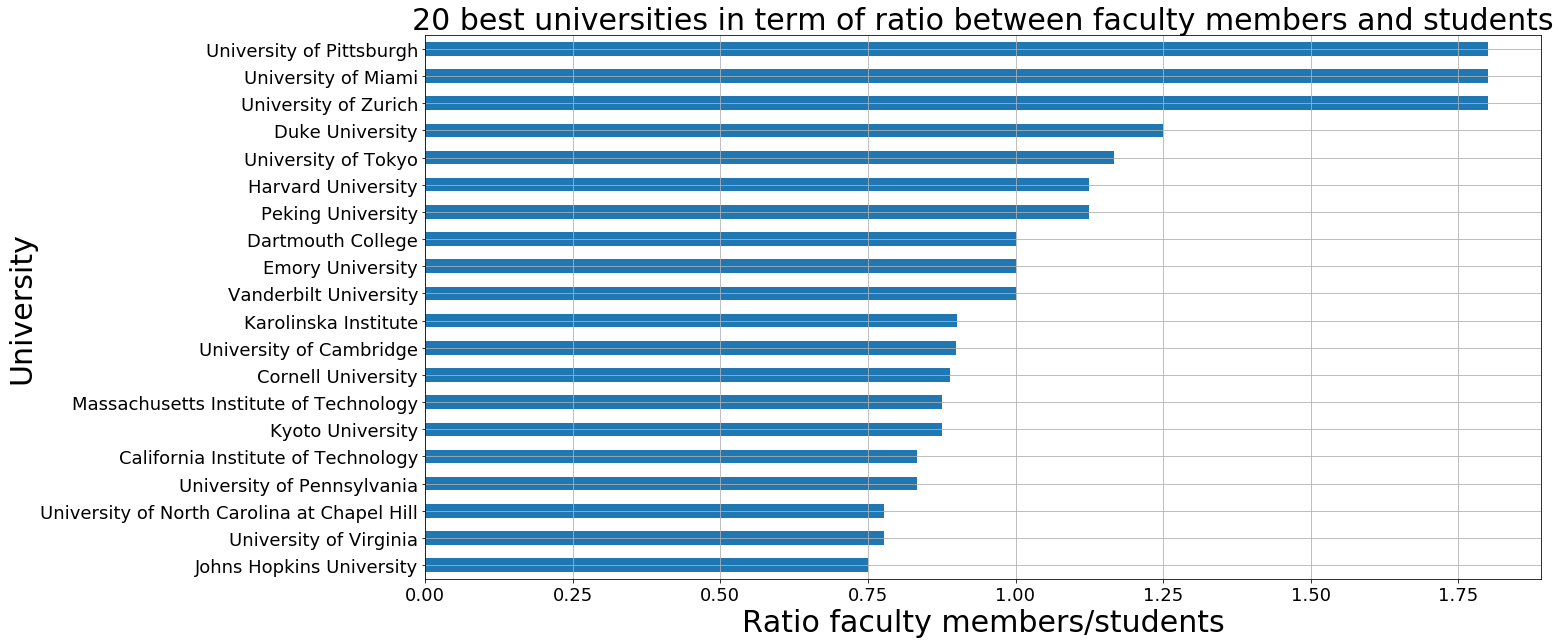

In [143]:
#We conpute the ratio between faculty members and students and add it in the data frame 
times_higher_education_ranking['ratio faculty members/students'] = compute_ratio(times_higher_education_ranking,
                                                                          'total faculty members (wur)',
                                                                          'total students (wur)')

#We display the ranking depending the ratio between faculty members and students
sorted_ranking(times_higher_education_ranking,'ratio faculty members/students')[['name','ratio faculty members/students']].head(20)

plot_barh_chart( times_higher_education_ranking , 'name', 'ratio faculty members/students', 
                '20 best universities in term of ratio between faculty members and students', 
                'Ratio faculty members/students', 'University' )

This is interesting to notice that we don't have the same results that for ranking of top University. Universities of Pittsburgh, Miami and Zurich are the best university in terms of ratio between faculty members and students whereas they do not appear on the top 20 for Top university ranking. The California Institute of Technology which had the lead on the 1st ranking is in the 15th position. We can assume that the Times and Top University don't count the faculty members in the same way.

* #####  Which are the best universities in term of ratio of international students?

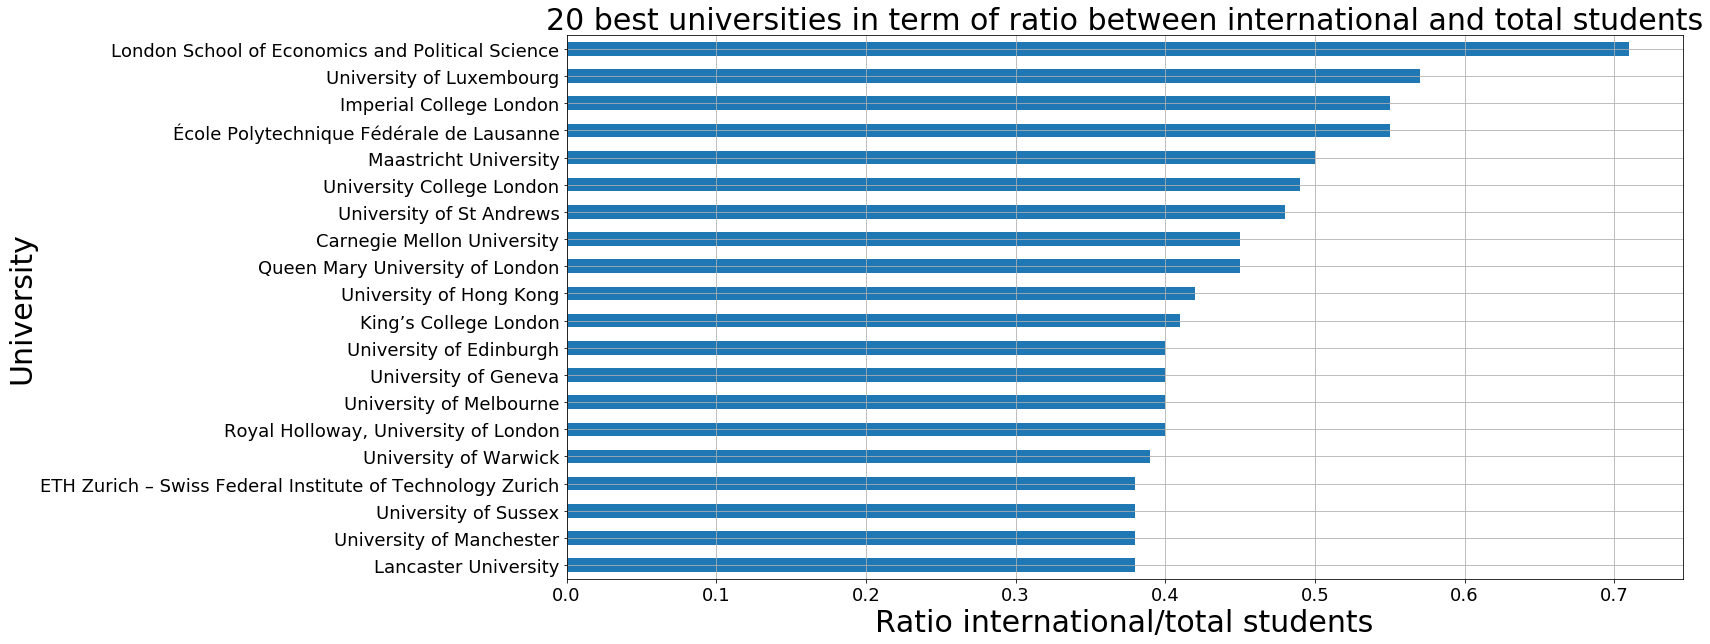

In [144]:
#We conpute the ratio between faculty members and students and add it in the data frame 
times_higher_education_ranking['ratio international/total students'] = compute_ratio(times_higher_education_ranking,
                                                                          'international students (wur)',
                                                                          'total students (wur)')

#We display the ranking depending the ratio between faculty members and students
sorted_ranking(times_higher_education_ranking,
               'ratio international/total students')[['name','ratio international/total students']].head(20)

plot_barh_chart( times_higher_education_ranking , 'name', 'ratio international/total students', 
                '20 best universities in term of ratio between international and total students', 
                'Ratio international/total students', 'University' )

This is interesting to see that EPFL is the forth best university in term of international students. This ranking is quite similar to the ranking of Top University.

* ##### Which are the best countries in term of ratio between faculty members and students?

There is two ways of considering the ratio of a country. We could take the total numbers of faculty members per country divided by the total numbers of students per country or the average ratio between all the universities of a country. 

We choose for the following questions to use the average ratio bewteen the different universities of a country, in order to give the same weight to every university.

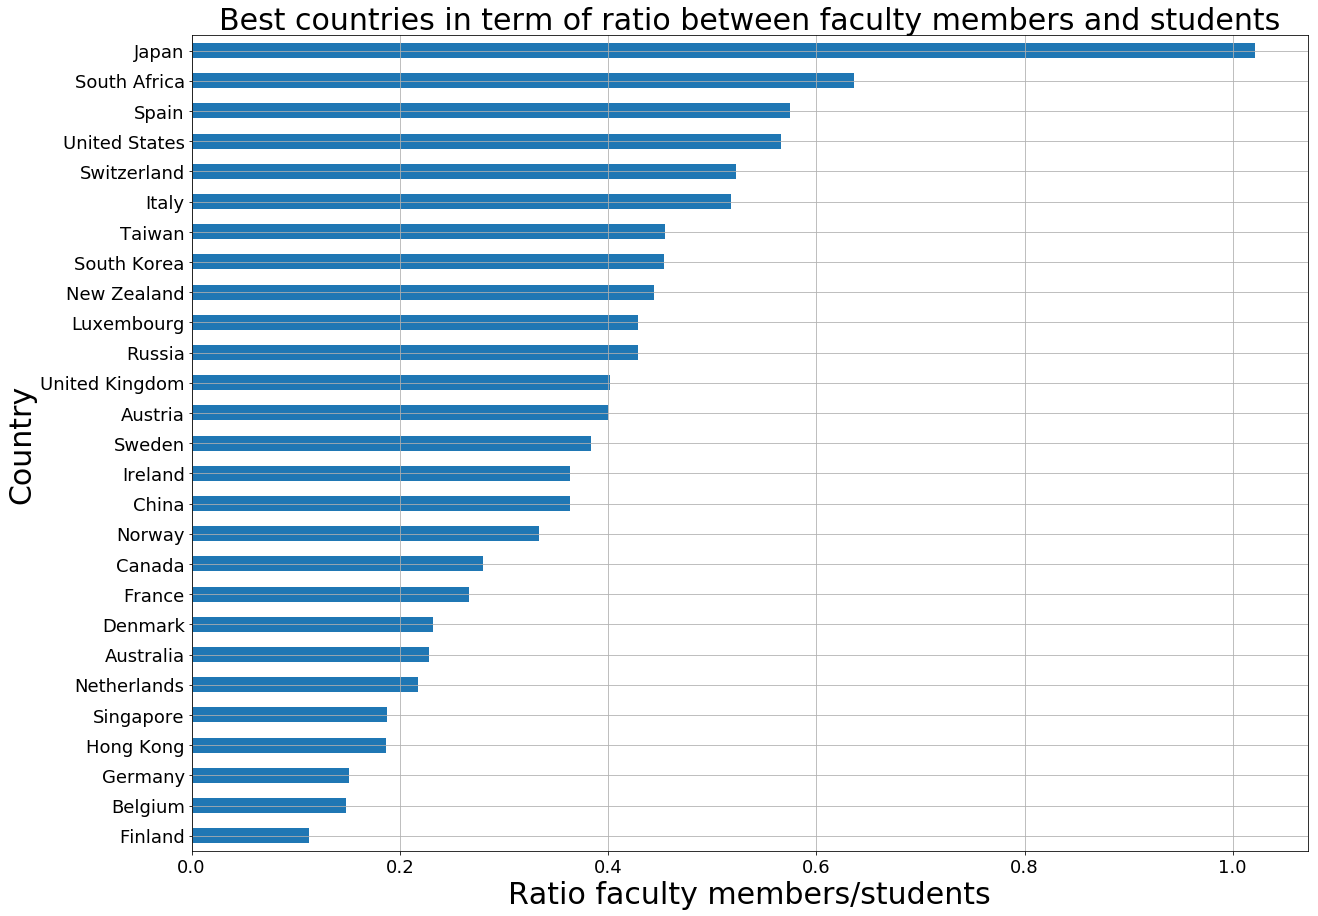

In [145]:
plot_barh_chart_groupedBy( times_higher_education_ranking , 'ratio faculty members/students', 
                'Best countries in term of ratio between faculty members and students', 
                'Ratio faculty members/students', 'Country', 'country', (20,15) ) 

Japan is the best country in term of ratio between faculty members and students according to this ranking.

* ##### Which are the best countries in term of ratio of international students?

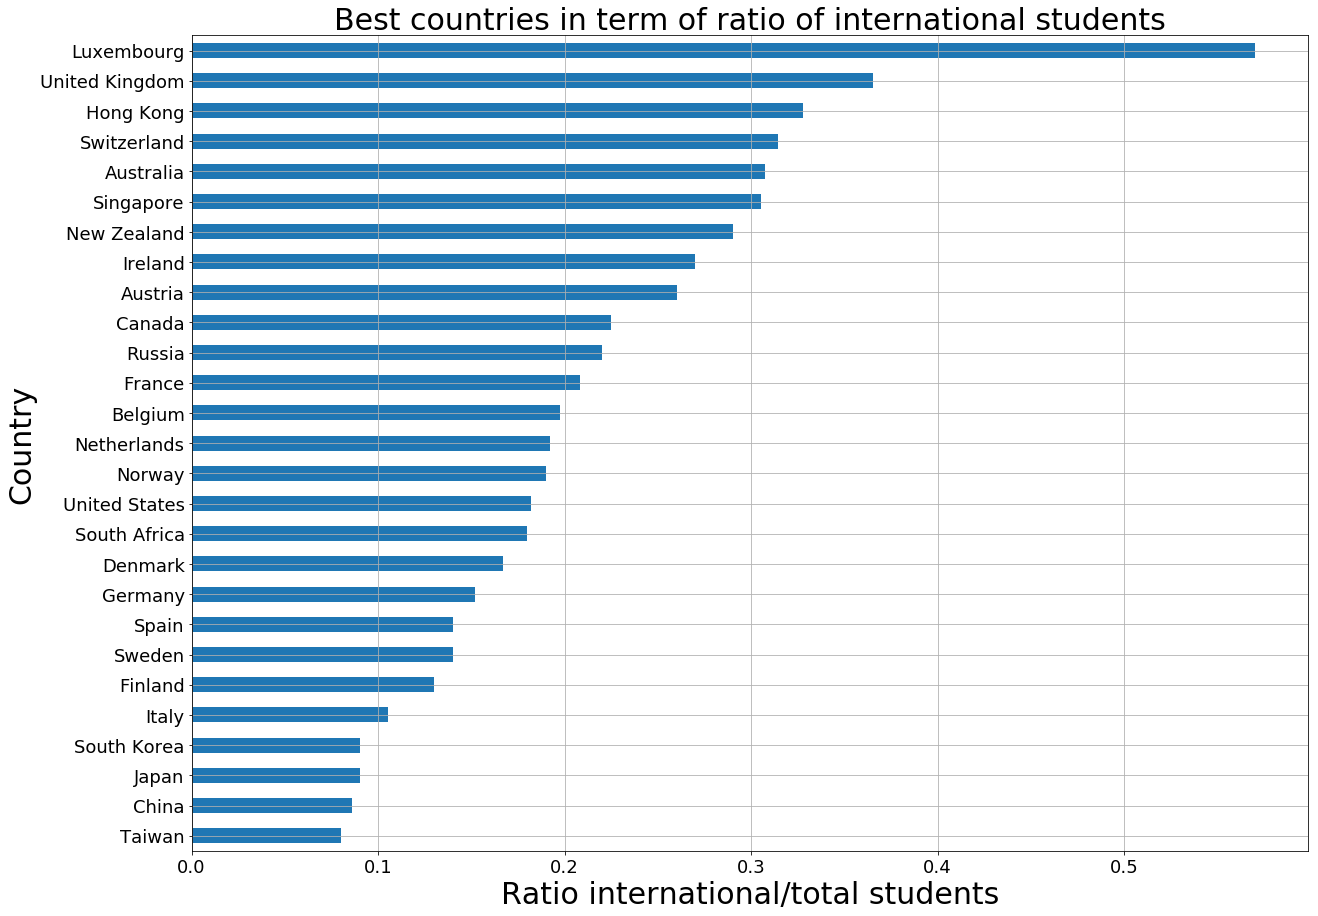

In [146]:
plot_barh_chart_groupedBy( times_higher_education_ranking , 'ratio international/total students', 
                'Best countries in term of ratio of international students', 
                'Ratio international/total students', 'Country', 'country', (20,15) ) 

This is interesting to see that Luxembourg is now the best country in term of ratio of international students, but only one university from Luxembourg is present in the ranking so it is maybe not relevant.

* ##### Which are the best regions in term of ratio between faculty members and students?

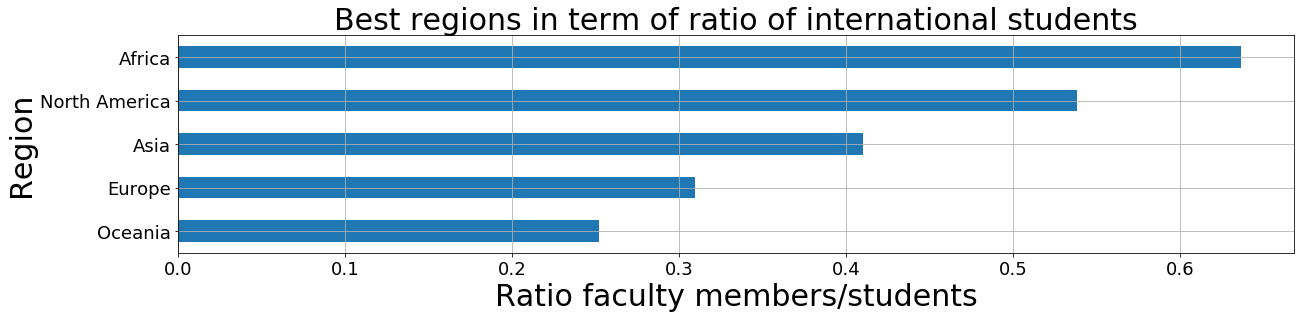

In [147]:
plot_barh_chart_groupedBy( times_higher_education_ranking , 'ratio faculty members/students', 
                'Best regions in term of ratio of international students', 
                'Ratio faculty members/students', 'Region', 'region', (20,4) ) 

Africa has the best ratio between faculty members and students (0.63 faculty menbers per students) while they are 4th in the Top University ranking (0.17 faculty menbers per students). We can guess that the ratio of faculty menbers per students is more important in the Times ranking.

* ##### Which are the best regions in term of ratio of international students?

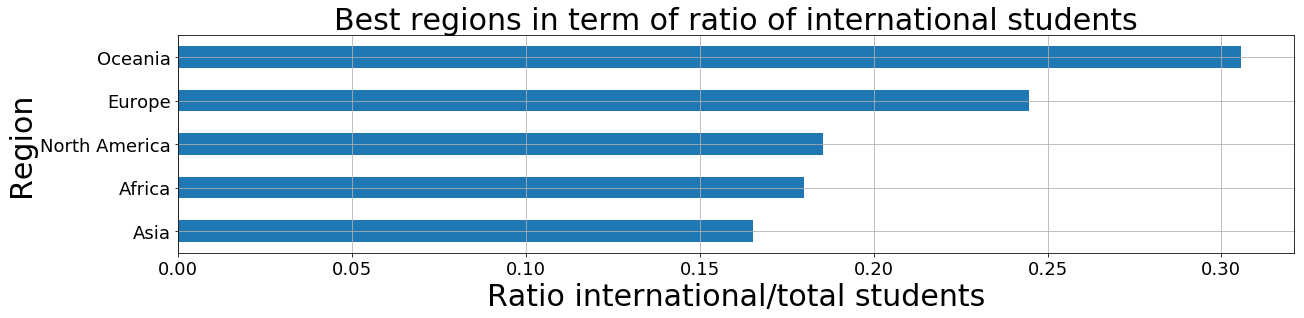

In [148]:
plot_barh_chart_groupedBy( times_higher_education_ranking , 'ratio international/total students', 
                'Best regions in term of ratio of international students', 
                'Ratio international/total students', 'Region', 'region', (20,4) ) 

Oceania host more international students in ratio. The Times ranking about the ratio of international students per region is similar to the results we had using Top University ranking. 

In [149]:
#We drop those 2 columns because they are not usefull for the next parts of the exercice
useless_columns = ['ratio faculty members/students','ratio international/total students']
times_higher_education_ranking = times_higher_education_ranking.drop(useless_columns,axis=1)

### 3) Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

`good_merge` is the dataframe containing the university which matches without any cleaning on the name (105)

In [150]:
good_merge = pd.merge(top_university_ranking, times_higher_education_ranking, on=['name','country','region'],how='inner')

`df1` corresponds to the dataframe of the first ranking without the universities whose have already been merged correctly.

`df2` corresponds to the dataframe of the second ranking without the universities whose have already been merged correctly.

In [151]:
df1=top_university_ranking
df2=times_higher_education_ranking

df1=df1[(~df1.name.isin(good_merge.name))]  #drop the university whose already merged well
df2=df2[(~df2.name.isin(good_merge.name))]

df1=df1.reset_index(drop=True)
df2=df2.reset_index(drop=True)


Sometimes, two universities don't match on the name field, because the name is actually not exactly the same, for example: *Massachusetts Institute of Technology (MIT)* and *Massachusetts Institute of Technology*.

We create a function filter which takes as input the name of a University of `df1`, and find the university name of `df2` which is the most similar, using `token_sort_ratio()` of `fuzzywuzzy` library. `token_sort_ratio()` attempts to account for similar strings out of order.

We then verify :
- that the country of the two universities are the same.
- that the token_sort_ratio is greater than 50

If the token_sort_ratio is greater than 80, we change the name of the university of `df1` with the university name of `df2`. Otherwise we also compare the number of students in both ranking, and if the difference is less than 5% we change the name of the university of `df1`.

In [152]:
def filter_(x):
    #Input: name of df1.
    
    list_=[] #to append the token_sort_ratio, with every name of df2
  
    
    for df2name in df2.name:
        
        list_.append(fuzz.token_sort_ratio(x, df2name))
    
    max_=max(list_) # max token_sort_ratio: corresponding to the most similar name.
    indice = list_.index(max_) #corresponding indice of the max
    

    y=df2.loc[indice,'name'] #university name of df2, with the max token_sort_ration

    
    country1=df1.loc[df1['name'] == x,'country'].values[0]
    country2=df2.loc[df2['name'] == y,'country'].values[0]
    
    if country1==country2:
        
        if max_>50:
            
            if max_>80:
                return y     
                
            else:
                std1=int(df1.loc[df1['name'] == x,'total students (tur)'].values[0])
                std2=int(df2.loc[df2['name'] == y,'total students (wur)'].values[0])
                ratio_=100*abs(std2-std1)/(std1+std2)
                
                if ratio_<10:
                    return y
            
                    
                else:
                    return x

        else :
            return x
        
    else:
        return x
    


Change the name of df1, using the previous function `filter`:

In [153]:
df1.name=df1.name.apply(lambda x: filter_(x))

Merge df1 and df2:

In [154]:
new_merge = pd.merge(df1,df2, on=['name','country','region'],how='inner')

Concatenate this `new_merge` with `good_merge`

In [155]:
results = pd.concat([good_merge,new_merge])
results = results.set_index(np.arange(0, results.name.count(), 1))
results

,name,rank (tur),country,region,total faculty members (tur),international faculty members (tur),total students (tur),international students (tur),rank (wur),total students (wur),total faculty members (wur),international students (wur)
0,Stanford University,2.0,United States,North America,4285.0,2042.0,15878.0,3611.0,4.0,15845,11318,3486
1,Harvard University,3.0,United States,North America,4350.0,1311.0,22429.0,5266.0,6.0,20326,22867,5285
2,University of Cambridge,5.0,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0,2.0,18389,16550,6436
3,University of Oxford,6.0,United Kingdom,Europe,6750.0,2964.0,19720.0,7353.0,1.0,20409,3711,7755
4,Imperial College London,8.0,United Kingdom,Europe,3930.0,2071.0,16090.0,8746.0,8.0,15857,5766,8721
5,University of Chicago,9.0,United States,North America,2449.0,635.0,13557.0,3379.0,9.0,13525,4508,3381
6,Princeton University,13.0,United States,North America,1007.0,246.0,8069.0,1793.0,7.0,7955,2983,1909
7,Cornell University,14.0,United States,North America,2718.0,970.0,21904.0,5411.0,19.0,21850,19422,5244
8,Yale University,16.0,United States,North America,4940.0,1708.0,12402.0,2469.0,12.0,12155,9116,2553
9,Johns Hopkins University,17.0,United States,North America,4462.0,1061.0,16146.0,4105.0,13.0,15498,11624,3720


## 4) Find useful insights in the data by performing an exploratory analysis.
Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

Set the value of the other classement if the value *international students* or *total students* is missing, and compute the average, and different ratio

In [156]:
#if number of student is unknown for one classement give the one of the other classement if it's unknow for both give 0
def get_mean( field ) :
    results[field + ' (tur)'] = results[field + ' (tur)'].fillna(results[field + ' (wur)'])
    results[field + ' (wur)'] = results[field + ' (wur)'].fillna(results[field + ' (tur)'])
    results[field] = np.mean( [results[field + ' (tur)'] ,  
                               results[field + ' (wur)'] ], axis = 0 )
    
get_mean( 'international students' ) 
get_mean( 'total students' )
get_mean( 'total faculty members')
get_mean( 'rank')

results=results.rename(index=str, columns={'international faculty members (tur)':'international faculty members',
                                           'rank': 'mean rank'})  



results['total international']=results['international students']+ results['international faculty members']
results['total student+faculty members']=results['total students']+results['total faculty members']


In [157]:
df_for_correlation=results[['mean rank','total faculty members','international faculty members','total students','international students']]

We are using pandas to create a correlation matrix to view the correlations between different variables in the dataframe

In [158]:
df_for_correlation.corr()

,mean rank,total faculty members,international faculty members,total students,international students
mean rank,1.000000,-0.217345,-0.487966,-0.095254,-0.310139
total faculty members,-0.217345,1.000000,0.265127,0.455438,0.227572
international faculty members,-0.487966,0.265127,1.000000,0.288003,0.578464
total students,-0.095254,0.455438,0.288003,1.000000,0.606132
international students,-0.310139,0.227572,0.578464,0.606132,1.000000


We can view these correlations graphically as a scatter matrix of the variables to check for linearity. The nearer the scatter of points is to a straight line, the higher is the strength of association between the variables.

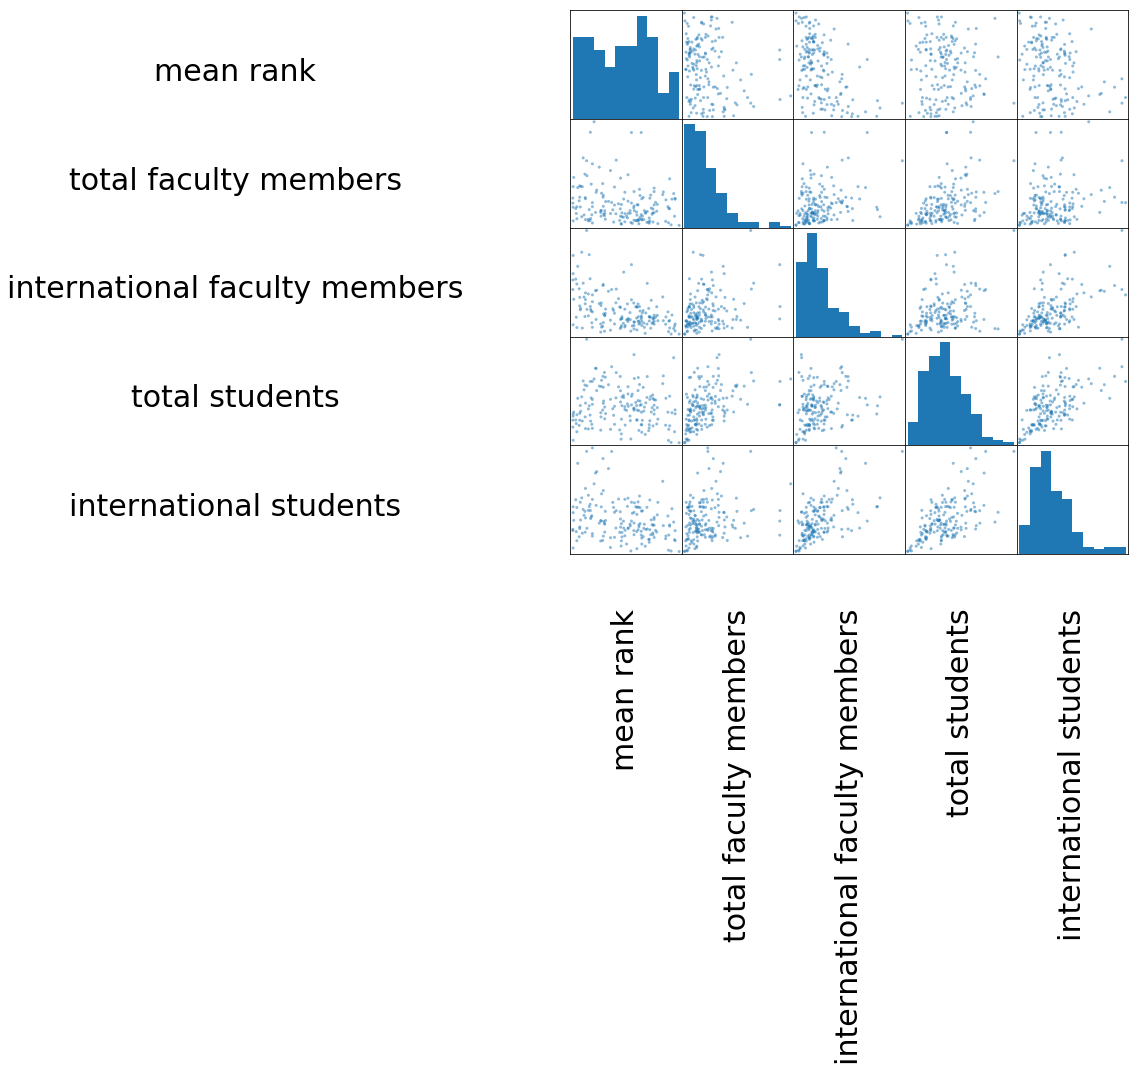

In [159]:
sm = pd.plotting.scatter_matrix(df_for_correlation, figsize=(10, 10))

#Label rotation
[s.xaxis.label.set_rotation(90) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#Offset labels
[s.get_yaxis().set_label_coords(-3,0.3) for s in sm.reshape(-1)]
[s.get_xaxis().set_label_coords(0.5,-0.5) for s in sm.reshape(-1)]

#Hide ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

According to the graph above, we can not establish any strong correlation between the columns of the dataset as there is no linear relationship between the variables. There is no strong relationship between two columns of the dataframe. 

The biggest correlations are between the number of international students and the total number of students (0.6) and  between the number of international students and international faculty members (0.57) but we see that there are a lot of university with many international faculty members those have a lower ratio of international student/faculty members than the average ratio.

### 5) Can you find the best university taking in consideration both rankings? Explain your approach.

We decide two takes as ranking the average ranking. 
As two universities could have the same ranking according to this criterion like ETH Zürich(10,10) and Princetown University(13,7), we choose to give importance when both rankings agree, so we create the variable ranking "rank difference" (this variable is 0 for ETH Zürich and 6 for Princetown University). With this second criterion ETh Zürcih has a better rank than Pricetown University, this prove that this is a good criterion.

As those two criteria could be equal: Uni1(42,44), Uni2(44,42): average=43 ; difference=2 ; we gave a third and last criterion which is the ratio *total faculty members/ total student*

Compute the *rank difference*, the *faculty members/student ratio* and the *mean rank*  were already computed)

In [163]:
results['rank difference'] = abs( results['rank (tur)'] - results['rank (wur)'] )
results['ratio falculty members/total student']=results['total faculty members']/results['total students']

Sort the dataframe according to those 3 criterions and dsiplay the top 10 universities 

In [165]:
results.sort_values(['mean rank', 'rank difference','ratio falculty members/total student'], ascending = [True, True, False], inplace=True)
results['final ranking'] = np.linspace(1.0, 160.0, num = 160)
results=results.set_index(['final ranking'])
results[['name','rank (tur)', 'rank (wur)','mean rank','rank difference']].head(10)

,name,rank (tur),rank (wur),mean rank,rank difference
final ranking,,,,,
1.0,Stanford University,2.0,4.0,3.0,2.0
2.0,Massachusetts Institute of Technology,1.0,5.0,3.0,4.0
3.0,California Institute of Technology,4.0,3.0,3.5,1.0
4.0,University of Cambridge,5.0,2.0,3.5,3.0
5.0,University of Oxford,6.0,1.0,3.5,5.0
6.0,Harvard University,3.0,6.0,4.5,3.0
7.0,Imperial College London,8.0,8.0,8.0,0.0
8.0,University of Chicago,9.0,9.0,9.0,0.0
9.0,ETH Zurich – Swiss Federal Institute of Techno...,10.0,10.0,10.0,0.0


**Stanford University** is be the best university if we group together top university and times higher education rankings